### Programming Assignment - Easy21
### Coded by Debanjan Mitra

## Easy 21 Rules:

-  The game is played with an infinite deck of cards (i.e. cards are sampled with replacement)
-  Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a colour of red (probability 1/3) or black (probability 2/3)
-  There are no aces or picture (face) cards in this game
- At the start of the game both the player and the dealer draw one black card in a fully observed fashion (aka they know each other first drawn cards)
- Each turn the player may either stick or hit
- If the player hits then she draws another card from the deck
- If the player sticks she receives no further cards
- The values of the player’s cards are added (black cards) or subtracted (red cards)
- If the player’s sum exceeds 21, or becomes less than 1, then she “goes bust” and loses the game (reward = -1)
- If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins (reward = 1); otherwise, the outcome – win (reward = +1), lose (reward = -1), or draw (reward = 0) – is the player with the largest sum.



### Let's start by importing the Python libraries that we'll need to run the code in this notebook.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import dill as pickle

### The code below is used to create the various graphs you'll see in the sections below.

In [ ]:
class utility():

  sns.set()

  def plot(Q, actions):

      from mpl_toolkits.mplot3d import Axes3D

      pRange = list(range(1,22))
      dRange = list(range(1,11))
      vStar = list()
      for p in pRange:
          for d in dRange:
              vStar.append( [p, d, np.max([Q[p, d, a] for a in actions])] )

      df = pd.DataFrame(vStar, columns=['player', 'dealer', 'value'])

      # And transform the old column name in something numeric
      df['player']=pd.Categorical(df['player'])
      df['player']=df['player'].cat.codes

      # Make the plot
      fig = plt.figure(figsize=(15, 10))
      ax = fig.gca(projection='3d')
      ax.plot_trisurf(df['dealer'], df['player'], df['value'], cmap=plt.cm.viridis, linewidth=0.2)
      plt.xlabel("Dealer Showing")
      plt.ylabel("Player sum")
      plt.show()

      # to Add a color bar which maps values to colors.
      surf=ax.plot_trisurf(df['dealer'], df['player'], df['value'], cmap=plt.cm.viridis, linewidth=0.2)
      fig.colorbar( surf, shrink=0.5, aspect=5)
      plt.show()

      # Rotate it
      ax.view_init(35, 45)
      plt.show()

      # Other palette
      ax.plot_trisurf(df['dealer'], df['player'], df['value'], cmap=plt.cm.jet, linewidth=0.01)
      plt.show()

  def plotMseEpisodesLambdas(arr):

      # https://stackoverflow.com/questions/45857465/create-a-2d-array-from-another-array-and-its-indices-with-numpy
      m,n = arr.shape
      I,J = np.ogrid[:m,:n]
      out = np.empty((m,n,3), dtype=arr.dtype)
      out[...,0] = I
      out[...,1] = J
      out[...,2] = arr
      out.shape = (-1,3)

      df = pd.DataFrame(out, columns=['lambda', 'Episode', 'MSE'])
      df['lambda'] = df['lambda'] / 10
      #df = df.loc[df.index % 100 == 0]
      g = sns.FacetGrid(df, hue="lambda", size=8, legend_out=True)
      #g.map(plt.scatter, "episode", "mse")
      g = g.map(plt.plot, "Episode", "MSE").add_legend()

      plt.subplots_adjust(top=0.9)
      g.fig.suptitle('Mean Squared Error per Episode')

      plt.show()

  def plotMseLambdas(data, lambdas):
      df = pd.DataFrame(data, columns=['MSE'])
      df['lambda'] = lambdas

      sns.pointplot(x=df['lambda'], y=df['MSE'])
      plt.title("Mean Squared Error per Lambda")
      plt.show()

# Implementing the Environment

In [ ]:
class Easy21():

# First, we are initializing the Easy21 class with min and max values of both the Player and the Dealer 
    def __init__(self):
        self.minCardValue, self.maxCardValue = 1, 10
        self.dealerUpperBound = 17
        self.gameLowerBound, self.gameUpperBound = 0, 21

# We are defining the action space which returns a value of 0 for Stick and 1 for Hit.
    @classmethod
    def actionSpace(self):
        return (0, 1)

# We are initializing the game by generating random values between 0 and 21, 1 and 10. 
    def initGame(self):
        return (np.random.randint(self.minCardValue, self.maxCardValue+1),
               np.random.randint(self.minCardValue, self.maxCardValue+1))

# We are defining the deck based on the following 
# a) Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a colour of red (probability 1/3) or black (probability 2/3).
# b) The game is played with an infinite deck of cards (i.e. cards are sampled with replacement).
# c) There are no aces or picture (face) cards in this game.

    def draw(self):
        value = np.random.randint(self.minCardValue, self.maxCardValue+1)

        if np.random.random() <= 1/3:
            return -value
        else:
            return value

# A function named “step” is defined, which takes three inputs (first one is playerValue which is between 1 and 21, second one is dealerValue which is between 1 and 10, and an action a (stick or hit), and then it returns the sample of next state (which may be terminal if the game is finished) and a reward.
# a)	At the start of the game both the player and the dealer draw one black card (fully observed)
# b)	Each turn the player may either stick or hit
# c)	If the player hits, then she draws another card from the deck
# d)	If the player sticks, she receives no further cards
# e)	The values of the player’s cards are added (black cards) or subtracted (red cards)
# f)	If the player’s sum exceeds 21, or becomes less than 1, then she “goes bust” and loses the game (reward -1)

    def step(self, playerValue, dealerValue, action):

        assert action in [0, 1], "Expection action in [0, 1] but got %i"%action

        if action == 0:

            playerValue += self.draw()

            # check if player busted
            if not (self.gameLowerBound < playerValue <= self.gameUpperBound):
                reward = -1
                terminated = True

            else:
                reward = 0
                terminated = False

        elif action == 1:
            terminated = True

            while self.gameLowerBound < dealerValue < self.dealerUpperBound:
                dealerValue += self.draw()

            # check if dealer busted // playerValue greater than dealerValue
            if not (self.gameLowerBound < dealerValue <= self.gameUpperBound) \
                or playerValue > dealerValue:
                reward = 1

            elif playerValue == dealerValue:
                reward = 0

            elif playerValue < dealerValue:
                reward = -1

        return playerValue, dealerValue, reward, terminated

This environment will be used for model-free reinforcement learning, hence the MDP transition matrix should not be explicitly represented. The dealer's actions should be treated as a component of the environment; for example, calling step with a stick action will play out the dealer's cards and return the ultimate prize and terminal state.

# Monte Carlo Control
We need to look into different options other than the best we know from time to time in order to come up with the best policy. <br>  <br> 
We'll use e-greedy exploration for this, which is one of the most basic notions for ensuring continuous exploration and is defined by:
- policy(a | st) = { probability 1 - e to choose the greedy action (the best we know, maxQ(st, a)),
                   probability e choose random action
                 }
We have our policy, let's check the pseudo-code for the MCPC. We improve our value function by sampling episodes and exploring the environment.

- for a big number of steps: <br> 
  Run one episode and store the states you've visited and the rewards you got. <br> 
  for every time-step t:
        Increment counter: N(St) ← N(St) + 1
        error ← (Gt − Q(St, At))
        Q(St, At) ← Q(St, At) + αt * error

For this exercise:

- e-greedy exploration strategy with e = N0/(N0 + N(st)), where N0 = 100 is a hyper-parameter, N(s) is the number of times that state s has been visited, and N(st) is the number of times that the state s has been visited.
- Initialise the value function to zero.
- Use a time-varying scalar step-size of αt = 1/N(st, at).

In [ ]:
printEvery = 10000
actions = [0, 1]

N0 = 100

# state, action function
Q = np.zeros((22, 11, len(actions)))

# number of times action a has been choosen in state s
NSA = np.zeros((22, 11, len(actions)))

# number of times state s has been visited
NS = lambda p, d: np.sum(NSA[p, d])

# step size
alpha = lambda p, d, a: 1/NSA[p, d, a]

# exploration probability
epsilon = lambda p, d: N0 / (N0 + NS(p, d))

def epsilonGreedy(p, d):
    if np.random.random() < epsilon(p, d):
        # explore
        action = np.random.choice(actions)

    else:
        # exploit
        action = np.argmax( [Q[p, d, a] for a in actions])

    return action

episodes = int(1e7)
meanReturn = 0
wins = 0

env = Easy21()

for episode in range(episodes):

    terminated = False
    SAR = list() # state, action, reward
    p, d = env.initGame()
    # Sample Environment
    while not terminated:

        a = epsilonGreedy(p, d)

        NSA[p, d, a] += 1

        pPrime, dPrime, r, terminated = env.step(p, d, a)

        SAR.append([p, d, a, r])

        p, d = pPrime, dPrime

    # Update Q
    G = sum([sar[-1] for sar in SAR]) # sum all rewards
    for (p, d, a, _) in SAR:
        Q[p, d, a] += alpha(p, d, a) * (G - Q[p, d, a])

    # bookkeeping
    meanReturn = meanReturn + 1/(episode+1) * (G - meanReturn)
    if r == 1:
        wins += 1

    if episode % printEvery == 0:
        print("Episode %i, Mean-Return %.3f, Wins %.2f"%(episode, meanReturn, wins/(episode+1)))

Episode 0, Mean-Return -1.000, Wins 0.00
Episode 10000, Mean-Return -0.052, Wins 0.47
Episode 20000, Mean-Return -0.026, Wins 0.49
Episode 30000, Mean-Return -0.011, Wins 0.49
Episode 40000, Mean-Return -0.005, Wins 0.50
Episode 50000, Mean-Return -0.001, Wins 0.50
Episode 60000, Mean-Return 0.004, Wins 0.50
Episode 70000, Mean-Return 0.007, Wins 0.50
Episode 80000, Mean-Return 0.012, Wins 0.51
Episode 90000, Mean-Return 0.014, Wins 0.51
Episode 100000, Mean-Return 0.016, Wins 0.51
Episode 110000, Mean-Return 0.017, Wins 0.51
Episode 120000, Mean-Return 0.019, Wins 0.51
Episode 130000, Mean-Return 0.021, Wins 0.51
Episode 140000, Mean-Return 0.021, Wins 0.51
Episode 150000, Mean-Return 0.023, Wins 0.51
Episode 160000, Mean-Return 0.024, Wins 0.51
Episode 170000, Mean-Return 0.025, Wins 0.51
Episode 180000, Mean-Return 0.026, Wins 0.51
Episode 190000, Mean-Return 0.027, Wins 0.51
Episode 200000, Mean-Return 0.027, Wins 0.51
Episode 210000, Mean-Return 0.029, Wins 0.51
Episode 220000, Me

## Plotting the values in Graph

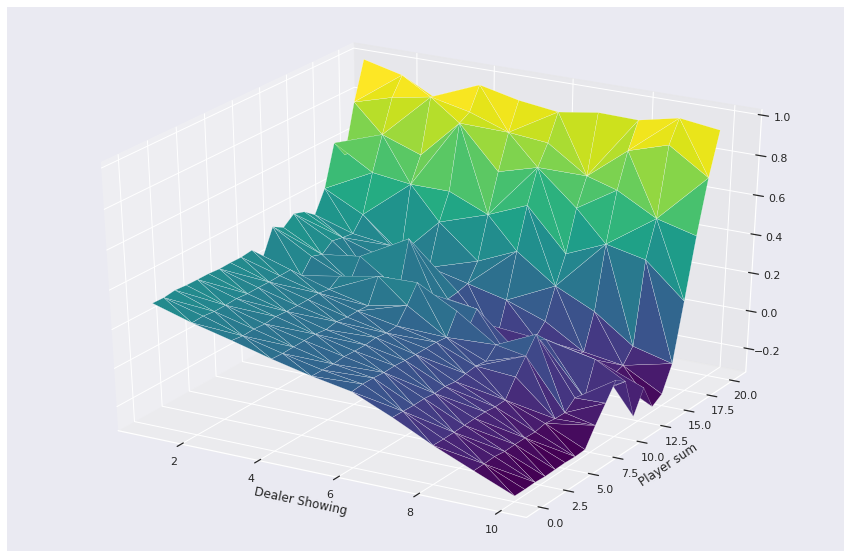

In [ ]:
pickle.dump(Q, open('Q.dill', 'wb'))
_ = pickle.load(open('Q.dill', 'rb')) # sanity check
utility.plot(Q, [0,1])

The game's 10 million episodes were analysed to produce the following Value function: The optimal Q value function becomes smoother as the number of samples increases. It's worth noting that states with a player sum close to 21 have a value of about 1. Furthermore, as the value of the dealer card rises, so does the value of the states. While the particular trend is obscured by noise and difficult to discern, it appears that when player sum equals 11, there is a local maximum. This is illustrated by the fact that if the player's total is 11, he or she cannot go bust in the next draw.

# Sarsa λ TD(λ) Control
Temporal difference learning is a model-free prediction method that bootstraps estimates of the action-value function Q and performs updates based on those estimates after each time step. Monte Carlo simulation must wait until the completion of an episode to get the cumulative returns Gt then average those returns to compute the value of a state and update Q. TD(λ) updates values based on bootstrapped estimates and therefore does not need to wait until the final outcome to make updates. TD(λ) is the averaging of n-backups and λ weights.

![alt text](https://tinyurl.com/yc3xumjh)

Sarsa λ is a method of TD control, so it employs the use of an eligibility trace to estimate the value of a state. An eligibility trace tells us how much credit/balance you should assign to each state/action. The main idea here is that when we make an update, we want to put more emphasis on the actions taken more recently that got us to where we are now. This is equivalent to saying we want to use more recent information to make a prediction about the future. Every time we get new information, we update our prediction.

![alt text](https://tinyurl.com/phbjnzzv)

Mathematically, this is implemented via the eligibility trace vector E(s,a). E(s,a) stores the decay factor for each state-action pair. The eligibility trace is applied to our TD error, δt, which is the difference between our prior estimate and the current estimate of Q.

The Sarsa pseudo-code is:

![alt text](https://tinyurl.com/33yczcsu)

In [ ]:
env = Easy21()
N0 = 100
actions = [0, 1]

def reset():
    Q = np.zeros((22, 11, len(actions))) # state-action value
    NSA = np.zeros((22, 11, len(actions))) # state-action counter
    wins = 0

    return Q, NSA, wins

Q, NSA, wins = reset()
trueQ = pickle.load(open('Q.dill', 'rb'))

# number of times state s has been visited
NS = lambda p, d: np.sum(NSA[p, d])

# step size
alpha = lambda p, d, a: 1/NSA[p, d, a]

# exploration probability
epsilon = lambda p, d: N0 / (N0 + NS(p, d))

def epsilonGreedy(p, d):
    if np.random.random() < epsilon(p, d):
        # explore
        action = np.random.choice(actions)

    else:
        # exploit
        action = np.argmax( [Q[p, d, a] for a in actions] )

    return action

#Stopping after 1000 episode
episodes = int(1e4)
lmds = list(np.arange(0,11)/10)

mselambdas = np.zeros((len(lmds), episodes))
finalMSE = np.zeros(len(lmds))

for li, lmd in enumerate(lmds):

    Q, NSA, wins = reset()

    for episode in range(episodes):

        terminated = False
        E = np.zeros((22, 11, len(actions))) # Eligibility Trace
        p, d = env.initGame()
        # inital state and first action
        a = epsilonGreedy(p, d)
        SA = list()

        # Sample Environment
        while not terminated:

            pPrime, dPrime, r, terminated = env.step(p, d, a)

            if not terminated:
                aPrime = epsilonGreedy(pPrime, dPrime)
                tdError = r + Q[pPrime, dPrime, aPrime] - Q[p, d, a]
            else:
                tdError = r - Q[p, d, a]

            E[p, d, a] += 1
            NSA[p, d, a] += 1
            SA.append([p, d, a])

            for (_p, _d, _a) in SA:
                Q[_p, _d, _a] += alpha(_p, _d, _a) * tdError * E[_p, _d, _a]
                E[_p, _d, _a] *= lmd

            if not terminated:
                p, d, a = pPrime, dPrime, aPrime

        # bookkeeping
        if r == 1:
            wins += 1

        mse = np.sum(np.square(Q-trueQ)) / (21*10*2)

        mselambdas[li, episode] = mse

        if episode % 1000 == 0 or episode+1==episodes:
            print("Lambda=%.1f Episode %06d, MSE %5.3f, Wins %.3f"%(lmd, episode, mse, wins/(episode+1)))

    finalMSE[li] = mse

    print("--------")

Lambda=0.0 Episode 000000, MSE 0.117, Wins 0.000
Lambda=0.0 Episode 001000, MSE 0.234, Wins 0.433
Lambda=0.0 Episode 002000, MSE 0.181, Wins 0.454
Lambda=0.0 Episode 003000, MSE 0.132, Wins 0.454
Lambda=0.0 Episode 004000, MSE 0.109, Wins 0.454
Lambda=0.0 Episode 005000, MSE 0.097, Wins 0.457
Lambda=0.0 Episode 006000, MSE 0.086, Wins 0.461
Lambda=0.0 Episode 007000, MSE 0.069, Wins 0.466
Lambda=0.0 Episode 008000, MSE 0.059, Wins 0.466
Lambda=0.0 Episode 009000, MSE 0.058, Wins 0.467
Lambda=0.0 Episode 009999, MSE 0.056, Wins 0.468
--------
Lambda=0.1 Episode 000000, MSE 0.116, Wins 1.000
Lambda=0.1 Episode 001000, MSE 0.231, Wins 0.428
Lambda=0.1 Episode 002000, MSE 0.174, Wins 0.447
Lambda=0.1 Episode 003000, MSE 0.132, Wins 0.460
Lambda=0.1 Episode 004000, MSE 0.104, Wins 0.457
Lambda=0.1 Episode 005000, MSE 0.086, Wins 0.462
Lambda=0.1 Episode 006000, MSE 0.072, Wins 0.465
Lambda=0.1 Episode 007000, MSE 0.062, Wins 0.466
Lambda=0.1 Episode 008000, MSE 0.060, Wins 0.468
Lambda=0.1 

The graph below presents changes of mean-squared error for different values of lambda: 0, 0.1, 0.2, ..., 1. For each value, 1000 episodes have been evaluated. We see that we get the lowest MSE at λ = 0.5 and the highest is obtained at λ = 1.0

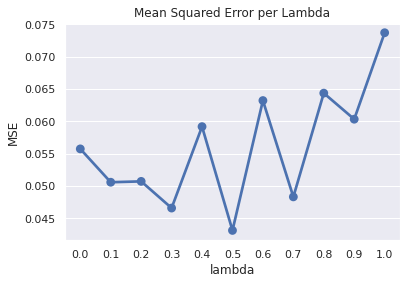

In [ ]:
utility.plotMseLambdas(finalMSE, lmds)

The MSE curves between ideal Q value and computed Q value, as well as the number of sampled episodes and different values, are depicted in the picture below. In comparison to the standard MCC approach (=1), the TD learning strategy (=0) requires fewer episodes to converge to the ideal Q value function.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


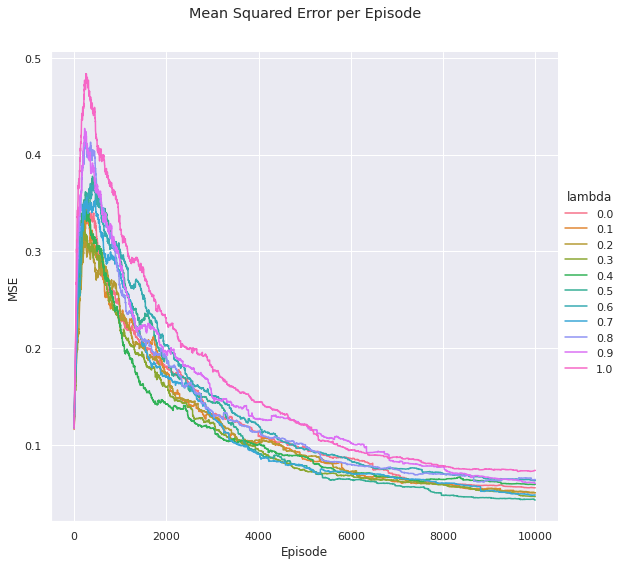

In [ ]:
utility.plotMseEpisodesLambdas(mselambdas)